c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
23.0
25.0
27.0
29.0
31.0
33.0
35.0
37.0
39.0
31.0
33.0
35.0
34.0
35.0
36.0
37.0
38.0
39.0
41.0
44.0
47.0
50.0
53.0
56.0
59.0
62.0
65.0
68.0
71.0
74.0
77.0
80.0
84.0
88.0
92.0
96.0
100.0
104.0
108.0
112.0
116.0
120.0
124.0
128.0
132.0
136.0
140.0
144.0
148.0
152.0
156.0
161.0
166.0
171.0
176.0
181.0
186.0
191.0
196.0
201.0
206.0
211.0
216.0
221.0
227.0
233.0
239.0
156.0
110.0
114.0
118.0
122.0
126.0
131.0
136.0
141.0
88.0
46.0
21.0
7.0
8.0
11.0
14.0
18.0
22.0
26.0
31.0
36.0
42.0
48.0
54.0
60.0
66.0
72.0
78.0
84.0
90.0
96.0
103.0
110.0
117.0
124.0
131.0
138.0
145.0
152.0
159.0
166.0
173.0
180.0
187.0
194.0
201.0
208.0
215.0
222.0
229.0
237.0
245.0
253.0
261.0
269.0
277.0
285.0
293.0
301.0
309.0
317.0
325.0
333.0
342.0
351.0
360.0
369.0


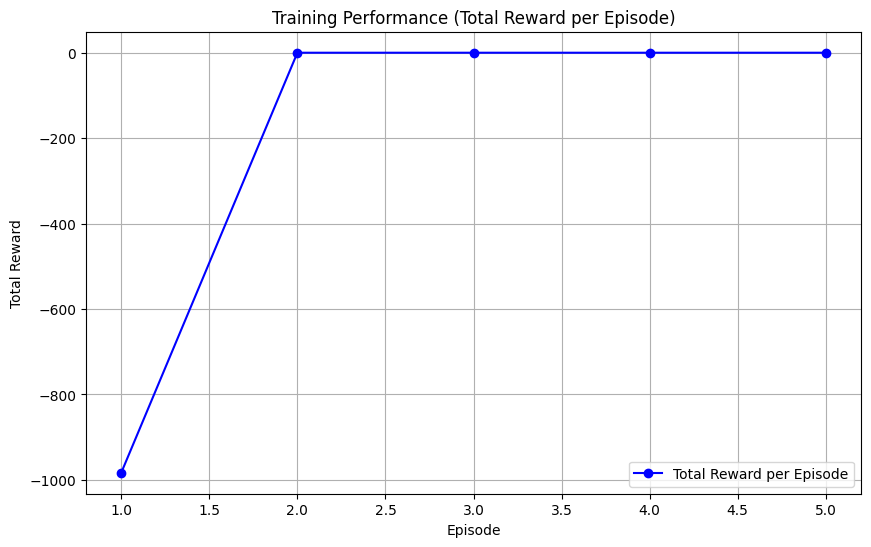

In [5]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import matplotlib.pyplot as plt  # Import Matplotlib for visualization

# --- Constants ---
STATE_DIM = 5  # Updated to 5 states
ACTION_DIM = 2  # Number of possible actions
GAMMA = 0.9  # Discount factor
ALPHA = 0.001  # Learning rate
EPSILON = 0.1  # Exploration factor
MEMORY_CAPACITY = 10000  # Replay memory size
BATCH_SIZE = 32  # Batch size for training
NUM_EPISODES = 30  # Number of training episodes

# --- Q-Network ---
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(STATE_DIM,)),  # Match input size
    tf.keras.layers.Dense(ACTION_DIM, activation='linear')  # Match action size
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')

# --- Replay Memory ---
memory = []

# --- Helper Functions ---
def get_state():
    """Fetch the current state from the simulator (e.g., SUMO)."""
    state = [
        traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
        traci.edge.getLastStepHaltingNumber("E4"),  # Number of halting vehicles in E4
        traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0 (highway)
        traci.edge.getWaitingTime("E4"),            # Waiting time in E4
        traci.edge.getWaitingTime("E5"),            # Waiting time in E5
    ]
    return np.array(state)

def choose_action(state):
    """Epsilon-greedy policy to select an action."""
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        state = state.reshape(1, -1)  # Ensure the state has correct dimensions
        q_values = model.predict(state, verbose=0)[0]
        return np.argmax(q_values)

def update_q_network():
    """Update the Q-network using replay memory."""
    if len(memory) < BATCH_SIZE:
        return
    
    # Randomly sample a minibatch from memory
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    minibatch = [memory[i] for i in indices]
    
    states = np.array([transition[0] for transition in minibatch])
    actions = np.array([transition[1] for transition in minibatch])
    rewards = np.array([transition[2] for transition in minibatch])
    next_states = np.array([transition[3] for transition in minibatch])
    terminals = np.array([transition[4] for transition in minibatch])
    
    q_values = model.predict(states, verbose=0)
    next_q_values = model.predict(next_states, verbose=0)
    
    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])
    
    model.fit(states, q_values, epochs=1, verbose=0)

# Reward calculation function (from your working example)
def calculate_reward(state):
    """Calculate the reward based on traffic metrics."""
    ramp_waiting_time = state[3] + state[4]  # Total ramp waiting time (E4 + E5)
    highway_flow = state[2]  # Highway flow is the average speed on E0
    max_ramp_waiting = 1000 # Example max ramp waiting time
    max_highway_speed = 50  # Example max highway speed
    print(ramp_waiting_time)
    # Normalize metrics
    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed
    
    # Weights
    alpha = 2.0  # Weight for ramp waiting time
    beta = 1.0   # Weight for highway flow
    
    # Basic reward
    reward = -alpha * normalized_rwt + beta * normalized_hf 
    
    # Penalty for extreme congestion (e.g., when ramp waiting time exceeds 80% of max)
    if ramp_waiting_time > max_ramp_waiting * 0.8:
        reward -= 10  # Strong penalty for high congestion
    
    return reward

def check_if_done():
    """Define termination condition."""
    return traci.simulation.getTime() > 1000  # Example: End after 1000 seconds

# --- Training Loop ---
traci.start(["sumo", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])  # Update with your SUMO config file
episode_rewards = []  # To store rewards per episode

for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0
    
    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)
        traci.trafficlight.setPhase("J7", action)  # Apply action (update traffic light phase)
        traci.simulationStep()  # Step simulation
        
        next_state = get_state()
        
        # Calculate reward based on traffic metrics
        reward = calculate_reward(state)
        
        done = check_if_done()
        
        # Store transition in replay memory
        memory.append((state, action, reward, next_state, done))
        if len(memory) > MEMORY_CAPACITY:
            memory.pop(0)
        
        update_q_network()
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    episode_rewards.append(total_reward)  # Store total reward for the episode
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

# Save the trained model
model.save("q_network_model.keras")

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, label="Total Reward per Episode", color="blue", marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Total Reward per Episode)")
plt.legend()
plt.grid(True)
plt.show()

# Close SUMO connection
traci.close()


In [4]:
traci.close()